<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, datetime, timedelta

In [2]:
uploaded3 = files.upload()

Saving L3.csv to L3 (1).csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))

In [67]:
NUM_TIME_BUCKETS = 96
NUM_DAYS_BACK = 2
TRAIN_DS_START = datetime(2019, 1, 3, 0, 0, 0)
TRAIN_DS_END = datetime(2019, 2, 28, 23, 59, 59)
VALIDATE_DS_START = datetime(2019, 3, 1, 0, 0, 0)
VALIDATE_DS_END = datetime(2019, 3, 31, 23, 59, 59)

In [68]:
df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
df['Date'] = pd.to_datetime(df['Date']).dt.date
df

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,139251010000000953,2019-01-01,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,260.604390,260.794296,261.618119,260.410437,256.860222,258.367665,259.267954,255.889186,256.234454,251.733526,253.060736,169.000653,174.316712,178.301884,177.104918,171.312698,164.677503,162.545790,163.696737,170.815170,165.797771,167.774777,162.219537,166.467952,170.952205,176.889430,185.207906,181.386608,181.008994,181.457673,184.951047,187.337285,190.128226,184.331248,183.509355,176.219448,167.887276,158.470484,150.323493,143.850835
1,139251010000000953,2019-01-02,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,262.614308,263.173392,263.352288,263.732740,260.200462,259.552441,261.542219,257.306632,257.454331,250.630975,246.677790,173.395331,173.247478,179.119319,181.130723,172.431674,167.940838,163.201839,159.947323,165.188458,158.381998,163.432975,151.094304,158.090667,159.554482,164.175128,174.279432,170.459428,168.864455,170.290711,169.613266,171.382665,161.363754,152.990980,146.391072,150.247456,143.614168,135.241240,131.278230,122.201884
2,139251010000000953,2019-01-03,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,208.367383,207.529761,206.938062,207.605235,205.509613,215.405268,226.547457,233.157517,243.354039,243.849967,246.386159,160.415138,165.446026,171.687940,172.159325,167.239343,166.621991,155.375629,146.709297,153.780523,145.743225,149.150742,138.501170,146.525020,148.044261,156.138623,169.157942,162.477838,162.238434,160.321249,161.024958,166.956953,165.855017,155.794104,155.492025,156.603946,147.835247,138.821851,133.105765,122.270591
3,139251010000000953,2019-01-04,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,185.176432,180.943482,178.127137,176.190525,172.771066,180.861096,190.123138,196.568212,207.176153,212.097792,221.633227,167.085154,173.514412,169.560842,162.695647,158.189749,161.720424,151.046653,141.837362,147.514554,142.901668,139.832138,139.984529,144.578787,152.116200,160.571161,172.932789,166.061648,163.764600,161.521083,162.501107,168.163179,170.013237,159.148580,166.698746,160.067192,150.799625,143.134452,135.886696,127.650203
4,139251010000000953,2019-01-05,105.965670,100.102905,91.755365,86.466442,82.576150,75.976198,72.498847,69.908311,73.935389,70.05197

In [69]:
def build_sequence_data(df, num_days_back = 2):
  df_join = pd.DataFrame.copy(df)
  for i in range(1, num_days_back+1):
    df_copy = pd.DataFrame.copy(df)
    df_copy['Date'] = df_copy['Date'] + pd.Timedelta(days=i)
    df_join = df_join.set_index(['Id', 'Date']).join(
        df_copy.set_index(['Id', 'Date']), rsuffix=f'_d{i}'
        ).reset_index()
  return df_join

df_join = build_sequence_data(df, 2)
df_join

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57_d2,TB58_d2,TB59_d2,TB60_d2,TB61_d2,TB62_d2,TB63_d2,TB64_d2,TB65_d2,TB66_d2,TB67_d2,TB68_d2,TB69_d2,TB70_d2,TB71_d2,TB72_d2,TB73_d2,TB74_d2,TB75_d2,TB76_d2,TB77_d2,TB78_d2,TB79_d2,TB80_d2,TB81_d2,TB82_d2,TB83_d2,TB84_d2,TB85_d2,TB86_d2,TB87_d2,TB88_d2,TB89_d2,TB90_d2,TB91_d2,TB92_d2,TB93_d2,TB94_d2,TB95_d2,TB96_d2
0,139251010000000953,2019-01-01,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,139251010000000953,2019-01-02,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,139251010000000953,2019-01-03,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,260.604390,260.794296,261.618119,260.410437,256.860222,258.367665,259.267954,255.889186,256.234454,251.733526,253.060736,169.000653,174.316712,178.301884,177.104918,171.312698,164.677503,162.545790,163.696737,170.815170,165.797771,167.774777,162.219537,166.467952,170.952205,176.889430,185.207906,181.386608,181.008994,181.457673,184.951047,187.337285,190.128226,184.331248,183.509355,176.219448,167.887276,158.470484,150.323493,143.850835
3,139251010000000953,2019-01-04,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,262.614308,263.173392,263.352288,263.732740,260.200462,259.552441,261.542219,257.306632,257.454331,250.630975,246.677790,173.395331,173.247478,179.119319,181.130723,172.431674,167.940838,163.201839,159.947323,165.188458,158.381998,163.432975,151.094304,158.090667,159.554482,164.175128,174.279432,170.459428,168.864455,170.290711,169.613266,171.382665,161.363754,152.990980,146.391072,150.247456,143.614168,135.241240,131.278230,122.201884
4,139251010000000953,2019-01-05,105.965670,100.102905,91.755365,86.466442,82.576150,75.976198,72.498847,69.908311,73.935389,70.051971,69.374191,63.801356,67.401895,66.049872,63.955424,64.409660,63.118381,62.814743,65.084950,62.170187,65.466127,63.186635,57.868451,56.703199,49.455674,55.335975,56.404408,63.527939,69.139564,82.221386,93.784116,106.628735,124.298886,129.912300,141.991337,154.238122,184.848056,181.826442,...,208.367383,207.529761,206.938062,207.605235,205.509613,215.405268,226.547457,233.157517,243.354039,243.849967,246.386159,160.415138,165.446026,171.

In [70]:
dim_features = NUM_DAYS_BACK + 4

def build_id_features(df, ds):
  df_groupby = df[(df['Date'] >= pd.Timestamp(ds+timedelta(days=-30))) & (df['Date'] < pd.Timestamp(ds))].drop(columns=['Date']).groupby(by=['Id'])
  df_id_features = df_groupby.min().join(df_groupby.max(), lsuffix='_min', rsuffix='_max').join(
      df_groupby.mean().join(df_groupby.std(), lsuffix='_mean', rsuffix='_std')
  )
  return df[['Id', 'Date']].set_index(['Id']).join(df_id_features).reset_index()

def split_feature_labels(df, dim_features):
  df_shape = df.shape
  x = df.iloc[:,2+96:].values.reshape(df_shape[0], dim_features, NUM_TIME_BUCKETS)
  x = x.swapaxes(1,2)
  y = df.iloc[:,2:2+96].values
  y = y.reshape([y.shape[0], y.shape[1], 1])
  # print(x.shape, y.shape)
  return (x, y)


# Build A DNN Model 

In [60]:
import tensorflow as tf 
keras = tf.keras

BATCH_SIZE = 128

In [95]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[NUM_TIME_BUCKETS, dim_features]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

print(model.summary())

optimizer = keras.optimizers.Adam(lr=5e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 32)            416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 32)            2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 32)            2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 32)            2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 32)            2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 1)             3

In [96]:
ds = TRAIN_DS_END + timedelta(days=1)
df_predicted = pd.DataFrame()
ds_list = []
nmae_list = []
while ds < VALIDATE_DS_END:
  df_id_features = build_id_features(df, ds)
  df_comined = df_join.set_index(['Id', 'Date']).join(df_id_features.set_index(['Id', 'Date'])).reset_index()
  df_train = df_comined[((df_comined['Date'] >= pd.Timestamp(ds + timedelta(days=-30))) & (df_comined['Date'] < pd.Timestamp(ds)))]
  df_validate = df_comined[((df_comined['Date'] >= pd.Timestamp(ds)) & (df_comined['Date'] < pd.Timestamp(ds + timedelta(days=1))))]
  x_train, y_train = split_feature_labels(df_train, dim_features)
  x_validate, y_validate = split_feature_labels(df_validate, dim_features)

  history = model.fit(x_train, y_train, epochs=50, batch_size = BATCH_SIZE,
                      validation_data=(x_validate, y_validate),
                      verbose=False)

  model = keras.models.load_model("my_checkpoint.h5")
  y_validate_predict = model.predict(x_validate, batch_size = BATCH_SIZE)
  nmae = np.mean(
      [np.mean(np.abs(y0.flatten()[-NUM_TIME_BUCKETS:]-y1.flatten()[-NUM_TIME_BUCKETS:])) / (max(y0.flatten()[-NUM_TIME_BUCKETS:]) - min(y0.flatten()[-NUM_TIME_BUCKETS:]))  for y0, y1 in zip(y_validate, y_validate_predict)]
  )
  print(ds, nmae)
  ds_list.append(ds)
  nmae_list.append(nmae)

  df_predicted_validate = pd.DataFrame.copy(df_validate.iloc[:,:2+96])
  df_predicted_validate.iloc[:,2:] = y_validate_predict.reshape(y_validate_predict.shape[0], y_validate_predict.shape[1])
  df_predicted = pd.concat([df_predicted, df_predicted_validate])

  ds = ds + timedelta(days=1)

2019-03-01 23:59:59 0.09145139676550385
2019-03-02 23:59:59 0.053427639678909476
2019-03-03 23:59:59 0.0745439979540393
2019-03-04 23:59:59 0.04891441083751227
2019-03-05 23:59:59 0.04646929550022864
2019-03-06 23:59:59 0.040972521783854396
2019-03-07 23:59:59 0.048335968542928966
2019-03-08 23:59:59 0.09629447391192808
2019-03-09 23:59:59 0.06052694083437063
2019-03-10 23:59:59 0.07633289858911142
2019-03-11 23:59:59 0.056781733703148006
2019-03-12 23:59:59 0.05494230877353343
2019-03-13 23:59:59 0.04504308492457689
2019-03-14 23:59:59 0.046293648403204206
2019-03-15 23:59:59 0.1093833194639992
2019-03-16 23:59:59 0.07889962008144329
2019-03-17 23:59:59 0.09621303219128426
2019-03-18 23:59:59 0.07845031258641995
2019-03-19 23:59:59 0.10393825525182639
2019-03-20 23:59:59 0.07364601447501463
2019-03-21 23:59:59 0.11830691651723224
2019-03-22 23:59:59 0.1530700961141164
2019-03-23 23:59:59 0.08484220028101319
2019-03-24 23:59:59 0.10206855691674904
2019-03-25 23:59:59 0.0856887766200507

In [97]:
print(np.mean(nmae_list))

0.0812258408558363


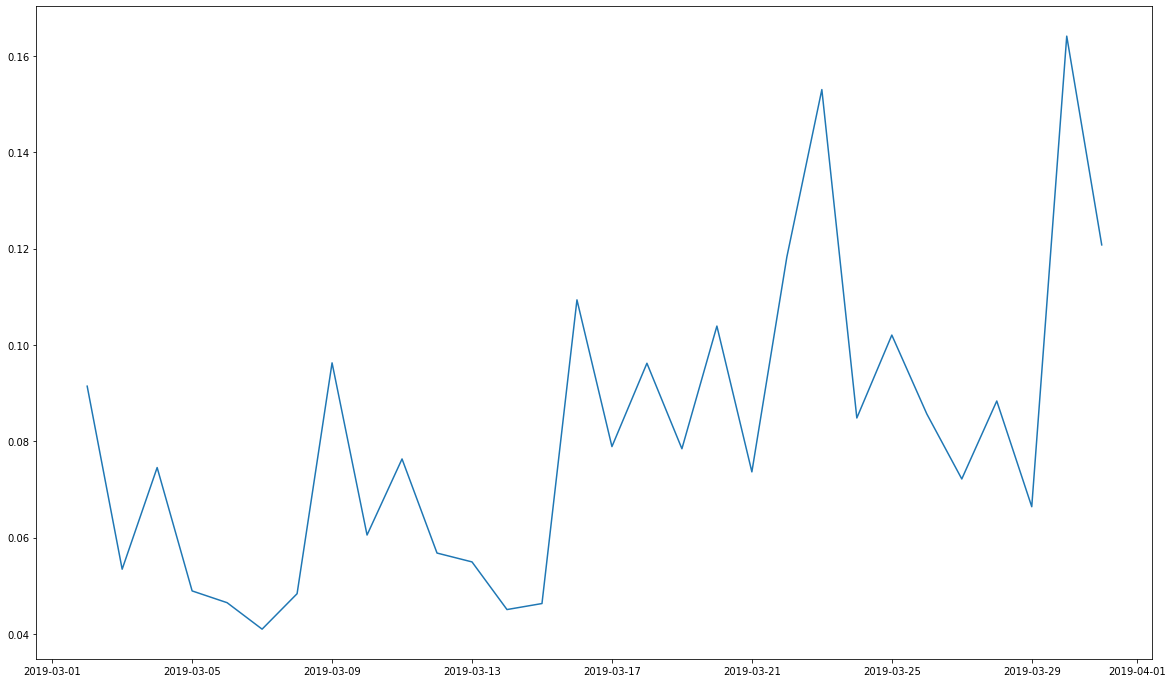

In [98]:
import matplotlib.pyplot as plt
ax = plt.figure(figsize=[20,12])
plt.plot(ds_list, nmae_list)